In [1]:
#!/usr/bin/python3
import pandas as pd
import numpy as np
import geopandas as gpd
import glob
import os
import json
from os.path import exists
import piecewise_regression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
# import pysal as ps
# from pysal.contrib.viz import mapping as maps
from shapely import wkt
from shapely.geometry import Polygon

import matplotlib
import matplotlib.pyplot as plt

In [3]:
# get data
dfs = [] # an empty list to store the data frames`
StartDir = '/Users/philipp/BPLA Dropbox/03 Planning/DN-Dumping Detection-1087/05_Output/Digitisation/Version-3/DD-lowest'

json_pattern = os.path.join(StartDir,'*.geojson')
file_list = glob.glob(json_pattern)
print(len(file_list))

for file in file_list:
    data = gpd.read_file(file, lines=True) # read data frame from json file
    dfs.append(data) # append the data frame to the list

# concatenate and format
piles = pd.concat(dfs)
piles['str_geom'] = piles['geometry'].apply(wkt.dumps)
piles['FIDint'] = piles['fid'].astype('int64')
len(piles)

# filter NA's for the cut
piles = piles[(piles.cut != 'NA')]
len(piles)
piles['cut'] = piles['cut'].astype('float64')
piles['volume'] = piles['volume'].astype('float64')

pilesNoNA = piles[(~piles['cut'].isnull())]

len(pilesNoNA)
pilesNoNA['Type'].value_counts()

#piles.to_file(StartDir+"/piles-west-lowest.shp")

# filter for duplicate geometry
pilesNoNA['str_geom_d'] = pilesNoNA.duplicated(subset=['str_geom'], keep=False)
pilesNoNA['str_geom_d'].value_counts()

# unique polygons
pilesNoNANoDup = pilesNoNA[pilesNoNA.str_geom_d == False]
len(pilesNoNANoDup)

pilesNoNADup = pilesNoNA[pilesNoNA.str_geom_d == True]
len(pilesNoNADup)
len(pilesNoNADup.str_geom.unique().tolist())

pilesNoNADupMax = pilesNoNADup.groupby('str_geom', group_keys=False).agg(max)
len(pilesNoNADupMax)

pilesNoNANoDupMax = pilesNoNADup[pilesNoNADup['cut'].isin(list(pilesNoNADupMax['cut']))]
len(pilesNoNANoDupMax)

final = pilesNoNANoDup.append(pilesNoNANoDupMax)


final['finalcut'] = final.duplicated(subset=['cut'], keep='first')
final['finalcut'].value_counts()
final = final[final.finalcut == False]
final['perimeter'] = final['geometry'].to_crs({'init': 'epsg:32638'}).map(lambda p: p.length)
final['area']=final['geometry'].to_crs({'init': 'epsg:32638'}).map(lambda p: p.area)
# output
final['Type'].value_counts()
final.groupby('Type', group_keys=False).agg(sum)['cut']
final.groupby('Type',group_keys=False).agg(sum)['volume']



8


/var/folders/zm/fb_kfkpj55zf4d6ywxmphdy40000gn/T/ipykernel_16416/2656426974.py:44: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  pilesNoNADupMax = pilesNoNADup.groupby('str_geom', group_keys=False).agg(max)
/var/folders/zm/fb_kfkpj55zf4d6ywxmphdy40000gn/T/ipykernel_16416/2656426974.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = pilesNoNANoDup.append(pilesNoNANoDupMax)
/Users/philipp/Projects/PycharmProjects/drone-deploy/venv/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-chang

6357


/Users/philipp/Projects/PycharmProjects/drone-deploy/venv/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/zm/fb_kfkpj55zf4d6ywxmphdy40000gn/T/ipykernel_16416/2656426974.py:60: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  final.groupby('Type', group_keys=False).agg(sum)['cut']
/var/folders/zm/fb_kfkpj55zf4d6ywxmphdy40000gn/T/ipykernel_16416/2656426974.py:61: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version

Type
Construction_Waste    172826.655553
Misc                   35639.726936
natural_Soil          480534.255823
Name: volume, dtype: float64

In [7]:
print(len(final))
print(final.groupby('Type',group_keys=False).agg(sum)['area'])
print(final.groupby('Type',group_keys=False).count()["FIDint"])

5897
Type
Construction_Waste    116824.067724
Misc                   36052.214165
natural_Soil          368043.563277
Name: area, dtype: float64
Type
Construction_Waste    1352
Misc                   382
natural_Soil          4163
Name: FIDint, dtype: int64


/var/folders/zm/fb_kfkpj55zf4d6ywxmphdy40000gn/T/ipykernel_16416/1870132868.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(final.groupby('Type',group_keys=False).agg(sum)['area'])


In [8]:
x = final['area']
y = final['cut']
data = list(zip(x, y))

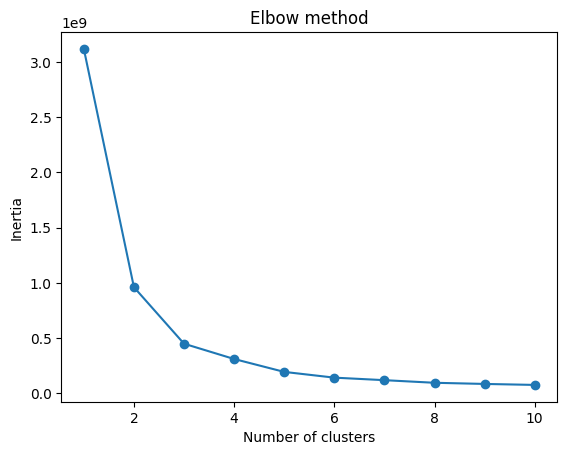

In [9]:
from sklearn.cluster import KMeans

inertias = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

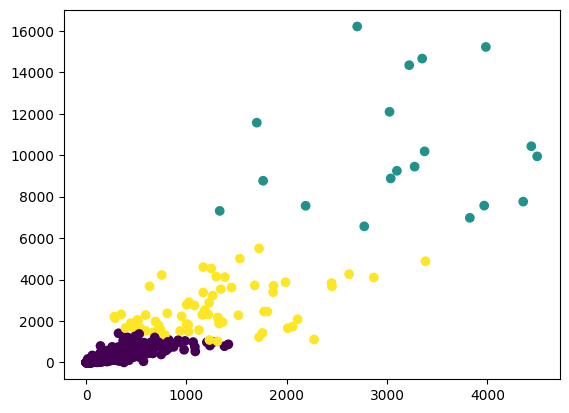

In [10]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(data)

plt.scatter(x, y, c=kmeans.labels_)
plt.show()


In [12]:
print(kmeans)

df = pd.DataFrame(data)
df['cluster'] = kmeans.labels_

cluster0 = df[(df["cluster"] == 0)]

cluster1 = df[df["cluster"] == 1]  # This is what you want

cluster2 = df[df["cluster"] == 2]  # This is what you want


KMeans(n_clusters=3)


In [13]:
regClu0 = LinearRegression().fit(cluster0[[0]],cluster0[[1]])
regClu1 = LinearRegression().fit(cluster1[[0]],cluster1[[1]])
regClu2 = LinearRegression().fit(cluster2[[0]],cluster2[[1]])

In [19]:
#LReg on small data sets only
toP = gpd.read_file('/Users/philipp/BPLA Dropbox/03 Planning/DN-Dumping Detection-1087/05_Output/Digitisation/Version-4-Worldview3/Final_New_Sat/final-new-sat-v2.geojson', lines=True)

toP['Type'] = toP['Type'].str.lower()
toP['area'] = toP['geometry'].to_crs({'init': 'epsg:32638'}).map(lambda p: p.area)

/Users/philipp/Projects/PycharmProjects/drone-deploy/venv/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [20]:
# individual predictions
# toP0 = toP[toP['area'] <= float(cluster0[[0]].max())]
# c0_pred = regClu0.predict(np.array(toP0['area']).reshape(-1, 1))
#
# # The coefficients
# print("Coefficients: \n", regClu0.coef_)
# # The mean squared error
# print("Mean squared error: %.2f" % mean_squared_error(toP0['area'], c0_pred))
# # The coefficient of determination: 1 is perfect prediction
# print("Coefficient of determination: %.2f" % r2_score(toP0['area'], c0_pred))
#
#
# toP1 = toP[toP['area'] < float(cluster1[[0]].max())]
# toP1 = toP1[toP1['area'] > float(cluster1[[0]].min())]
#
# # The coefficients
# print("Coefficients: \n", regClu1.coef_)
# # The mean squared error
# print("Mean squared error: %.2f" % mean_squared_error(toP1['area'], c1_pred))
# # The coefficient of determination: 1 is perfect prediction
# print("Coefficient of determination: %.2f" % r2_score(toP1['area'], c1_pred))
#
#
# # The coefficients
# print("Coefficients: \n", regClu2.coef_)
# # The mean squared error
# print("Mean squared error: %.2f" % mean_squared_error(toP2['area'], c2_pred))
# # The coefficient of determination: 1 is perfect prediction
# print("Coefficient of determination: %.2f" % r2_score(toP2['area'], c2_pred))
#
#
#
# c1_pred = regClu1.predict(np.array(toP1['area']).reshape(-1, 1))
#
# toP2 = toP[toP['area'] >float(cluster2[[0]].min())]
# c2_pred = regClu2.predict(np.array(toP2['area']).reshape(-1, 1))

# global prediction
# toP = toP[toP['area'] <= float(cluster0[[0]].max())]
c_pred = regClu0.predict(np.array(toP['area']).reshape(-1, 1))
print(toP.shape)
# The coefficients
print("Coefficients: \n", regClu1.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(toP['area'], c_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(toP['area'], c_pred))



(15468, 8)
Coefficients: 
 [[0.28355352]]
Mean squared error: 139.70
Coefficient of determination: 0.95


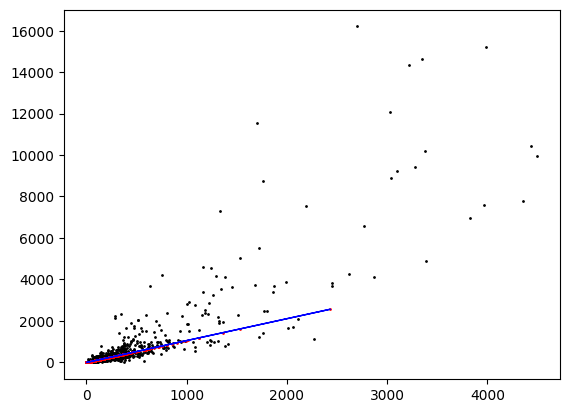

In [21]:
# Plot outputs
c_pred.shape= (-1,1)

plt.scatter(x, y, color="black",s=1)
plt.scatter(toP['area'], c_pred, color="red",s=1)
plt.plot(toP['area'], c_pred, color="blue", linewidth=1)

plt.show()

In [25]:
print(toP.groupby('Type',group_keys=False).agg(sum)['pred'])
print(toP.groupby('Type',group_keys=False).agg(sum)['area'])
print(toP.groupby('Type',group_keys=False).count())
# print(toP)
# toP['ratio']=toP['cut'].divide(toP['area'])
# toP['ratio'].describe()

Type
construction_waste    197084.926384
misc                    4858.765651
natural_soil          219358.444126
Name: pred, dtype: float64
Type
construction_waste    272427.352849
misc                    6443.081737
natural_soil          319402.582569
Name: area, dtype: float64
                    OBJECTID    Id  Shape_Leng  Shape_Le_1  Shape_Area  \
Type                                                                     
construction_waste      6580  6580        6580        6659        6659   
misc                     143   143         143         143         143   
natural_soil            8633  8633        8633        8666        8666   

                    geometry  area  pred  
Type                                      
construction_waste      6659  6659  6659  
misc                     143   143   143  
natural_soil            8666  8666  8666  


/var/folders/zm/fb_kfkpj55zf4d6ywxmphdy40000gn/T/ipykernel_16416/937717564.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(toP.groupby('Type',group_keys=False).agg(sum)['pred'])
/var/folders/zm/fb_kfkpj55zf4d6ywxmphdy40000gn/T/ipykernel_16416/937717564.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(toP.groupby('Type',group_keys=False).agg(sum)['area'])


In [ ]:
# x = np.sort(5 * np.random.rand(42, 1), axis=0)
# y = np.sin(x).ravel()
# y[::5] += 3 * (0.5 - np.random.rand(9))

In [ ]:
finalSmall = final[final['area'] < 100]

x = np.array(finalSmall['area']).reshape((-1, 1))
y = np.array(finalSmall['cut']).reshape((-1, 1))

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.optimize import leastsq
#
# #x, y = np.array([0,1,2,3,4,5]), np.array([0,1,4,9,16,25])
#
# # initial_guess[i] maps to p[x] in function_to_fit, must be reasonable
# initial_guess = [1, 1, 1]
#
# def function_to_fit(x, p):
#     return pow(p[0]*x, 2) + p[1]*x + p[2]
#
# def residuals(p,y,x):
#     return y - function_to_fit(x,p)
#
# cnsts = leastsq(
#     residuals,
#     initial_guess,
#     args=(y, x)
# )[0]
#
# fig, ax = plt.subplots()
# ax.plot(x, y, 'o')
#
# xi = np.arange(0,100,10)
# ax.plot(xi, [function_to_fit(x, cnsts) for x in xi])
#
# plt.show()

In [ ]:


# toP.groupby('Type',group_keys=False).agg(sum)['volume']
# toP['area']=toP['geometry'].to_crs({'init': '32638:3395'}).map(lambda p: p.area )

# total = final.append(toP)
# total['ratio']=total['cut'].divide(total['area'])



In [ ]:
print(toP['ratio'].describe())